# Medical Image Analysis: Neural Networks

Follow these instructions (https://github.com/antoniosehk/keras-tensorflow-windows-installation) and apply everything that is needed to run tensorflow and keras. Check if your computer has GPU compatible with NVIDIA drivers. If it is not compatible or you do not have GPU, there are two options available:

1) Use CPU. Our project is not going to be super computationally expensive

2) Use Colab, follow the first lecture and check here https://colab.research.google.com/notebooks/gpu.ipynb

# Exercise

## Database

There is a database with chest X-rays with lung segmentaiton. Please use imread from pyplot to read X-rays and lung masks as follows:

Loaded lung mask of shape (1024, 1024)


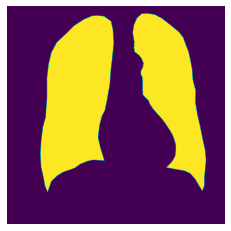

In [1]:
# reading gif images as numpy arrays
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

path = "scratch/"

leftLung = Image.open("Data/scratch/fold1/masks/left lung/JPCLN001.gif")
rightLung = Image.open("Data/scratch/fold1/masks/right lung/JPCLN001.gif")
bothLungs = np.array(leftLung) + np.array(rightLung)

print(f"Loaded lung mask of shape {bothLungs.shape}")
axes = plt.imshow(bothLungs)
_ = plt.axis("off")

Loaded lung image of shape (256, 256)


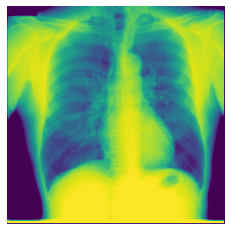

In [2]:
lungImage = Image.open("Data/scratch/images/JPCLN001.bmp").convert("L")
lungImageArray = np.array(lungImage)
print(f"Loaded lung image of shape {lungImageArray.shape}")
axes = plt.imshow(lungImageArray)
_ = plt.axis("off")

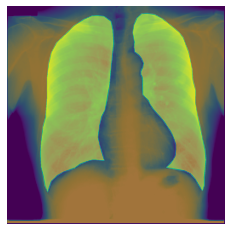

In [3]:
# overlap to verify
IMAGE_SHAPE = lungImageArray.shape[0:2]
resized_both_lungs = np.array(leftLung.resize(IMAGE_SHAPE)) + np.array(rightLung.resize(IMAGE_SHAPE))
assert resized_both_lungs.shape == IMAGE_SHAPE, "shapes of images and masks do not match!"

plt.imshow(lungImageArray)
plt.imshow(resized_both_lungs, alpha=0.5)
_ = plt.axis("off")

Exercise 1.1. Read the assignemtn data and separate it into training and testing parts

All raw X-ray images are stored at "Data\scratch\images".
The training and testing masks of the database are stored in two folders named "Data\scratch\fold1\masks\" and "Data\scratch\fold2\masks\", repsectively. The organs of interest include "left lung" and "right lung"

generate 4 numpy arrays mask_array_training, im_array_training, mask_array_testing, im_array_testing:

    0) n_training_cases = len(glob.glob('...Data\scratch\fold1\masks\left lung\'))
       n_testing_cases = len(glob.glob('...Data\scratch\fold2\masks\left lung\'))
    
    
    1) mask_array_training # should be of size (n_training_cases x 256 x 256) generated from images in folders "Data\scratch\fold1\masks\left lung" and "Data\scratch\fold1\masks\right lung".
    
    2) im_array_training # should be of size (n_training_cases x 256 x 256) generated from images in folder "Data\scratch\images". To be sure get case name from every file in "Data\scratch\fold1\masks\left lung" and find the matching file in "Data\scratch\images"
    
        a) files = glob.glob('...Data\scratch\fold1\masks\left lung\')
        b) fileName = os.path.basename(files[i])
        c) fileNameWithoutExtension = os.path.splitext(fileName)[0]
    
    3) mask_array_testing # should be of size (n_testing_cases x 256 x 256) generated from images in folder "Data\scratch\fold2\masks\left lung" and "Data\scratch\fold2\masks\right lung".
    
    4) im_array_testing # should be of size (n_testing_cases x 256 x 256) generated from images in folder "Data\scratch\images" to match testing masks in "Data\scratch\fold2\masks\left lung".

In [ ]:
import os
import glob

IMAGE_ROOT_PATH = "Data/scratch/images"
TRAIN_MASK_ROOT = "Data/scratch/fold1/masks"
TEST_MASK_ROOT = "Data/scratch/fold2/masks"

n_train_cases = len(os.listdir(f"{TRAIN_MASK_ROOT}/left lung"))
n_test_cases = len(os.listdir(f"{TEST_MASK_ROOT}/left lung"))
print(f"Found {n_train_cases} train cases")
print(f"Found {n_test_cases} test cases")


train_left_lung_masks = sorted(os.listdir(f"{TRAIN_MASK_ROOT}/left lung"))
train_right_lung_masks = sorted(os.listdir(f"{TRAIN_MASK_ROOT}/right lung"))
assert train_left_lung_masks == train_right_lung_masks, "mismatch between left and right train lung masks"

test_left_lung_masks = sorted(os.listdir(f"{TEST_MASK_ROOT}/left lung"))
test_right_lung_masks = sorted(os.listdir(f"{TEST_MASK_ROOT}/right lung"))
assert test_left_lung_masks == test_right_lung_masks, "mismatch between left and right test lung masks"

def get_joint_mask_as_array(mask_name, root_path, image_shape=(256, 256)):
    left_lung = Image.open(f"{root_path}/left lung/{mask_name}")
    right_lung = Image.open(f"{root_path}/right lung/{mask_name}")
    both_lungs_array = np.array(leftLung.resize(image_shape)) + np.array(rightLung.resize(image_shape))
    
    return both_lungs_array

def get_image_as_array(image_name, root_path):
    return np.array(Image.open(f"{root_path}/{image_name[:-3]}bmp").convert("L"))


mask_array_training = np.stack([get_joint_mask_as_array(x, TRAIN_MASK_ROOT, IMAGE_SHAPE) for x in train_left_lung_masks], 0)
mask_array_testing = np.stack([get_joint_mask_as_array(x, TEST_MASK_ROOT, IMAGE_SHAPE) for x in test_left_lung_masks], 0)

im_array_training = np.stack([get_image_as_array(x, IMAGE_ROOT_PATH) for x in train_left_lung_masks], 0)
im_array_testing = np.stack([get_image_as_array(x, IMAGE_ROOT_PATH) for x in test_left_lung_masks], 0)

print("Completed loading data")

In [ ]:
assert mask_array_training.shape[0] == n_train_cases, "missing train masks"
assert mask_array_testing.shape[0] == n_test_cases, "missing test masks"

print(f"Loaded train masks to array of shape {mask_array_training.shape}")
print(f"Loaded test masks to array of shape {mask_array_testing.shape}")

assert im_array_training.shape[0] == n_train_cases, "missing train masks"
assert im_array_testing.shape[0] == n_test_cases, "missing test masks"

print(f"Loaded train images to array of shape {im_array_training.shape}")
print(f"Loaded test images to array of shape {im_array_testing.shape}")

# Train UNet

Exercise 1.2. Adapt some existing implementation of Unet for the segmentation of lung fields. Train the Unet on fold1 of the database.

Check this link for Unet implementation https://github.com/zhixuhao/unet

Here is the implementation of the Unet https://github.com/zhixuhao/unet/blob/master/model.py
Move learning rate (lr) to the parameters of the unet()

Here is an example of how to visualize results of network training, you will need them for your report https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Some implementation hits for training Unets:

    0) par_batch_size = 10
       par_epochs = 100
       par_validation_split = 0.15
       par_learning_rate = 0.0001
       # play with these parameters to find best combination

    1) model = unet(input_size = (256, 256, 1), lr = par_learning_rate) # generate Unet
        
    2) validationSplit = 0.15
       
    3) im_array_training = np.expand_dims(np.asarray(im_array_training), axis = 4)
       mask_array_training = np.expand_dims(np.asarray(mask_array_training, dtype = np.float), axis = 4)
       # this is needed to add an explicit dimension at the end of the training data. You can basically consider this as color of the image. You add one dimension of size one to indicate that there is only one data channel per input example
        
    4) model.fit(im_array_training, mask_array_training, batch_size = par_batch_size, epochs = par_epochs, validation_split = par_validation_split)
    
    5) model.save('../resultUnet.hdf5') # save model somewhere on your disk

In [77]:
import numpy as np 
import os

import skimage.io as io
import skimage.transform as trans

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1), lr=1e-4):
    # check the links for a suitable Unet implementation and adapt it for lung fields

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer = Adam(lr = lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [78]:
par_batch_size = 32
par_epochs = 100
par_validation_split = 0.15
par_learning_rate = 0.0001

validationSplit = 0.15

im_array_training = np.expand_dims(np.asarray(im_array_training, dtype = np.float), axis = 3)
mask_array_training = np.expand_dims(np.asarray(mask_array_training > 0, dtype = np.float), axis = 3)

print(f"Converted arrays to shape {im_array_training.shape} for inputs and {mask_array_training.shape} for targets.")

Converted arrays to shape (124, 256, 256, 1) for inputs and (124, 256, 256, 1) for targets.


In [79]:
model = unet(input_size = (256, 256, 1), lr=par_learning_rate)

In [80]:
history = model.fit(im_array_training, 
                    mask_array_training, 
                    batch_size=par_batch_size, 
                    epochs=par_epochs, 
                    validation_split=par_validation_split)

Epoch 1/100
4/4 [==============================] - 2s 621ms/step - loss: 4444.1260 - accuracy: 0.4526 - val_loss: 419.8441 - val_accuracy: 0.6624
Epoch 2/100
4/4 [==============================] - 2s 561ms/step - loss: 299.7210 - accuracy: 0.6661 - val_loss: 79.2819 - val_accuracy: 0.7096
Epoch 3/100
4/4 [==============================] - 2s 561ms/step - loss: 138.8323 - accuracy: 0.6617 - val_loss: 97.9791 - val_accuracy: 0.6631
Epoch 4/100
4/4 [==============================] - 2s 561ms/step - loss: 70.0920 - accuracy: 0.6261 - val_loss: 72.9341 - val_accuracy: 0.6833
Epoch 5/100
4/4 [==============================] - 2s 593ms/step - loss: 50.5053 - accuracy: 0.7263 - val_loss: 16.3516 - val_accuracy: 0.8075
Epoch 6/100
4/4 [==============================] - 2s 570ms/step - loss: 25.0326 - accuracy: 0.6997 - val_loss: 53.5466 - val_accuracy: 0.6906
Epoch 7/100
4/4 [==============================] - 2s 570ms/step - loss: 18.1775 - accuracy: 0.7747 - val_loss: 20.2059 - val_accuracy: 0

In [82]:
model.save('resultUnet.hdf5')

In [83]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


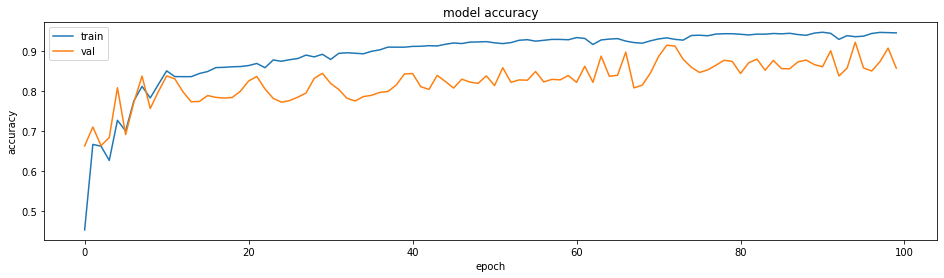

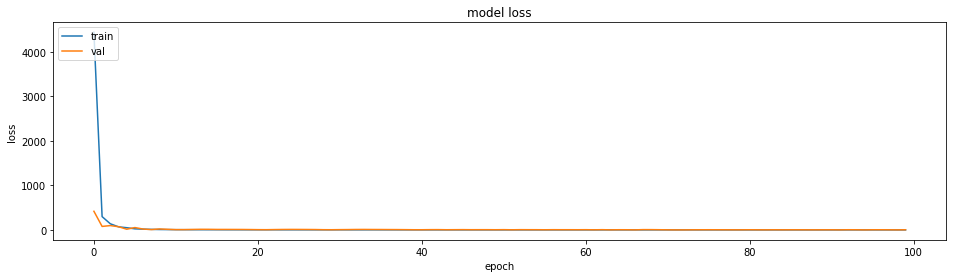

In [123]:
# summarize history for accuracy
plt.figure(figsize=(16, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(16, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test Unet

Exercise 1.3. Test the Unet performance on fold2. Use Dice coefficient to evaluate the Unet performance.

Some implementation hits for testing Unet:
    
    0) model = load_model('../resultUnet.hdf5') # load model
    
    1) results = model.predict(np.expand_dims(np.asarray(im_array_testing), axis = 4), batch_size = 5)
    
    2) results[i, :, :, 0] # this is the result of segmentation corresponding to im_array_testing[i]
    
    3) compute_dice(results[i, :, :, 0], mask_array_testing[i]) # compute the dice for ith testing images

In [7]:
from tensorflow.keras.models import *

model = load_model('resultUnet.hdf5')

results = model.predict(np.expand_dims(np.asarray(im_array_testing[:10]), axis=3))
plt.imshow(results[2] > 0.5)

AttributeError: type object 'h5py.h5a.AttrID' has no attribute '__reduce_cython__'

In [ ]:
all_results = model.predict(np.expand_dims(np.asarray(im_array_testing), axis=3))

In [ ]:
print(all_results.shape, mask_array_testing.shape)

In [ ]:
def compute_dice(prediction, target):
    dice = np.sum(prediction[target > 0]) * 2.0 / (np.sum(prediction) + np.sum(target))
    return dice

In [ ]:
dice_scores = []
for pred, y_hat in zip(all_results[:, :, :, 0], mask_array_testing):
    dice_scores.append(compute_dice(pred > 0.5, y_hat > 0))

In [ ]:
print(f"average dice score for {len(dice_scores)} images is: {sum(dice_scores) / len(dice_scores):.4f}")

# Tasks for the report

1) Train and test Unet for segmentation of lung fields.

2) Select appropriate par_batch_size, par_epochs, par_validation_split, par_learning_rate. Explain what these parameters mean and how did you choice
   (check this https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

3) Plot loss functions for training and validation

4) Plot results for cases JPCLN016, JPCLN048, JPCLN058. Explain why you think the results look like this.

In [ ]:
idx_list = ['JPCLN016.gif', 'JPCLN048.gif', 'JPCLN058.gif']

mask_array_exp = np.stack([get_joint_mask_as_array(x, TEST_MASK_ROOT, IMAGE_SHAPE) for x in idx_list], 0)
im_array_exp = np.stack([get_image_as_array(x, IMAGE_ROOT_PATH) for x in idx_list], 0)
results_exp = model.predict(np.expand_dims(np.asarray(im_array_exp), axis=3))

print(mask_array_exp.shape, im_array_exp.shape, results_exp.shape)

In [ ]:
for idx, name in enumerate(idx_list):
    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    plt.imshow(im_array_exp[idx])
    plt.imshow(results_exp[idx] > 0.5, alpha=0.5)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(im_array_exp[idx])
    plt.imshow(mask_array_exp[idx] > 0, alpha=0.5)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(im_array_exp[idx])
    plt.axis("off")

In [ ]:
print(f"average dice score for {len(dice_scores)} test images is: {sum(dice_scores) / len(dice_scores):.4f}")